In [3]:
import networkx as nx
import graph_tool.all as gt
import glob
import ast
import gzip


def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, bytes):
        # Encode the key as ASCII
        key = key.encode('ascii', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, bytes):
        tname = 'string'
        value = value.encode('ascii', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

GROUPS =  ["RooibosTea_QR_1216_1646", "RooibosTea_QL_1216_1646", "MexHotChoc_QR_1216_1646", "MexHotChoc_QL_1216_1646", "20230213_1745_AlmdudlerGspritzt_C1", "20230213_1745_AlmdudlerGspritzt_C0", "20221209_1613_QR", "20221209_1613_QL", "20221123_1543_AmericanoLatte_QR", "20221123_1543_AmericanoLatte_QL"]

# Create a dictionary to store the graphs
graphs = {}

for group in GROUPS:
    files = glob.glob(f'/Users/wolf/git/queenright-queenless-analysis/raw_data/edgelists/raw/{group}*.edgelist.gz')
    group_graphs = {}

    # Create a set to store all nodes in the current group
    all_nodes_in_group = set()

    # Create an aggregate graph for the current group
    aggregate_graph = nx.DiGraph()

    for file in files:
        hour = file.split('_')[-1].split('.')[0]

        with gzip.open(file, 'rt') as f:
            lines = f.readlines()

        nxG = nx.DiGraph()

        for line in lines:
            data = line.strip().split(' ')
            node1 = data[0].split('.')[0]
            node2 = data[1].split('.')[0]
            
            all_nodes_in_group.add(node1)
            all_nodes_in_group.add(node2)
            edge_data = ast.literal_eval(' '.join(data[2:]))
            if "weight" not in edge_data:
                edge_data['weight'] = edge_data['count']
            nxG.add_edge(node1, node2, **edge_data)

            # Add the edge to the aggregate graph, summing the weights
            if aggregate_graph.has_edge(node1, node2):
                aggregate_graph[node1][node2]['weight'] += edge_data['weight']
            else:
                aggregate_graph.add_edge(node1, node2, **edge_data)

        group_graphs[int(hour)] = nxG

    # Add missing nodes to each graph in the current group
    for hour, graph in group_graphs.items():
        for node in all_nodes_in_group:
            if node not in graph.nodes():
                graph.add_node(node)

    # Convert the NetworkX graphs to graph-tool graphs
    for graph in group_graphs:
        group_graphs[graph] = nx2gt(group_graphs[graph])

    # Convert the aggregate graph to a graph-tool graph and add it to the group graphs
    group_graphs['aggregate'] = nx2gt(aggregate_graph)

    graphs[group] = group_graphs

In [8]:
graphs['20221123_1543_AmericanoLatte_QR'][0].ep.log_count.a

PropertyArray([2.08278537, 1.50514998, 1.70757018, ..., 2.01703334,
               1.11394335, 1.77815125])

In [14]:
import matplotlib.pyplot as plt

In [18]:

def calculate_metrics_and_visualize(g):
    # Calculate Betweenness Centrality
    vertex_betweenness, edge_betweenness = gt.betweenness(g)
    g.vertex_properties["vertex_betweenness"] = vertex_betweenness
    g.edge_properties["edge_betweenness"] = edge_betweenness

    # Calculate Closeness Centrality
    closeness = gt.closeness(g)
    g.vertex_properties["closeness"] = closeness

    # Community Detection (Louvain Method)
    state = gt.minimize_nested_blockmodel_dl(g,dict(recs=[g.ep.weight],rec_types=["discrete-binomial"]))
    blocks = state.get_blocks()
    g.vertex_properties["blocks"] = blocks

    # Prepare for visualization
    # Normalize betweenness for visualization purposes
    norm_vertex_betweenness = g.new_vertex_property("double")
    max_vertex_betweenness = max(vertex_betweenness.a)
    for v in g.vertices():
        norm_vertex_betweenness[v] = (vertex_betweenness[v] / max_vertex_betweenness) * 10  # Scaling for visibility
    
    return g, norm_vertex_betweenness, blocks


for group in GROUPS:
    g, nvb, blocks = calculate_metrics_and_visualize(graphs[group]['aggregate'])
    pos = gt.sfdp_layout(g)
    gt.graph_draw(g, pos, vertex_fill_color=nvb, vertex_size=gt.prop_to_size(nvb, mi=5, ma=15), output=f'../figures/aggregate_graph_{group}.png')


In [ ]:

for group in GROUPS:
    g, nvb, blocks = calculate_metrics_and_visualize(graphs[group]['aggregate'])
    pos = gt.sfdp_layout(g)
    gt.graph_draw(g, pos, vertex_fill_color=nvb, vertex_size=gt.prop_to_size(nvb, mi=5, ma=15), output=f'../figures/aggregate_graph_{group}.png')


In [33]:
g = graphs['MexHotChoc_QL_1216_1646']['aggregate']
state = gt.minimize_nested_blockmodel_dl(g,state_args=dict(recs=[g.ep.log_count],rec_types=["real-normal"]))

# Annealing
gt.mcmc_anneal(state, beta_range=(1, 10), niter=100, mcmc_equilibrate_args=dict(force_niter=10))

# Equilibration
gt.mcmc_equilibrate(state, wait=10, mcmc_args=dict(niter=10))
bs = [] # collect some partitions

def collect_partitions(s):
   global bs
   bs.append(s.get_bs())

# Now we collect partitions for exactly 1,000 sweeps, at intervals
# of 10 sweeps:
gt.mcmc_equilibrate(state, force_niter=100, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

/Users/wolf/miniforge3/envs/qrql/lib/python3.12/site-packages/graph_tool/__init__.py:2004: SyntaxWarning: invalid escape sequence '\m'
  """Return the edge from vertex ``s`` to ``t``, if it exists. If


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

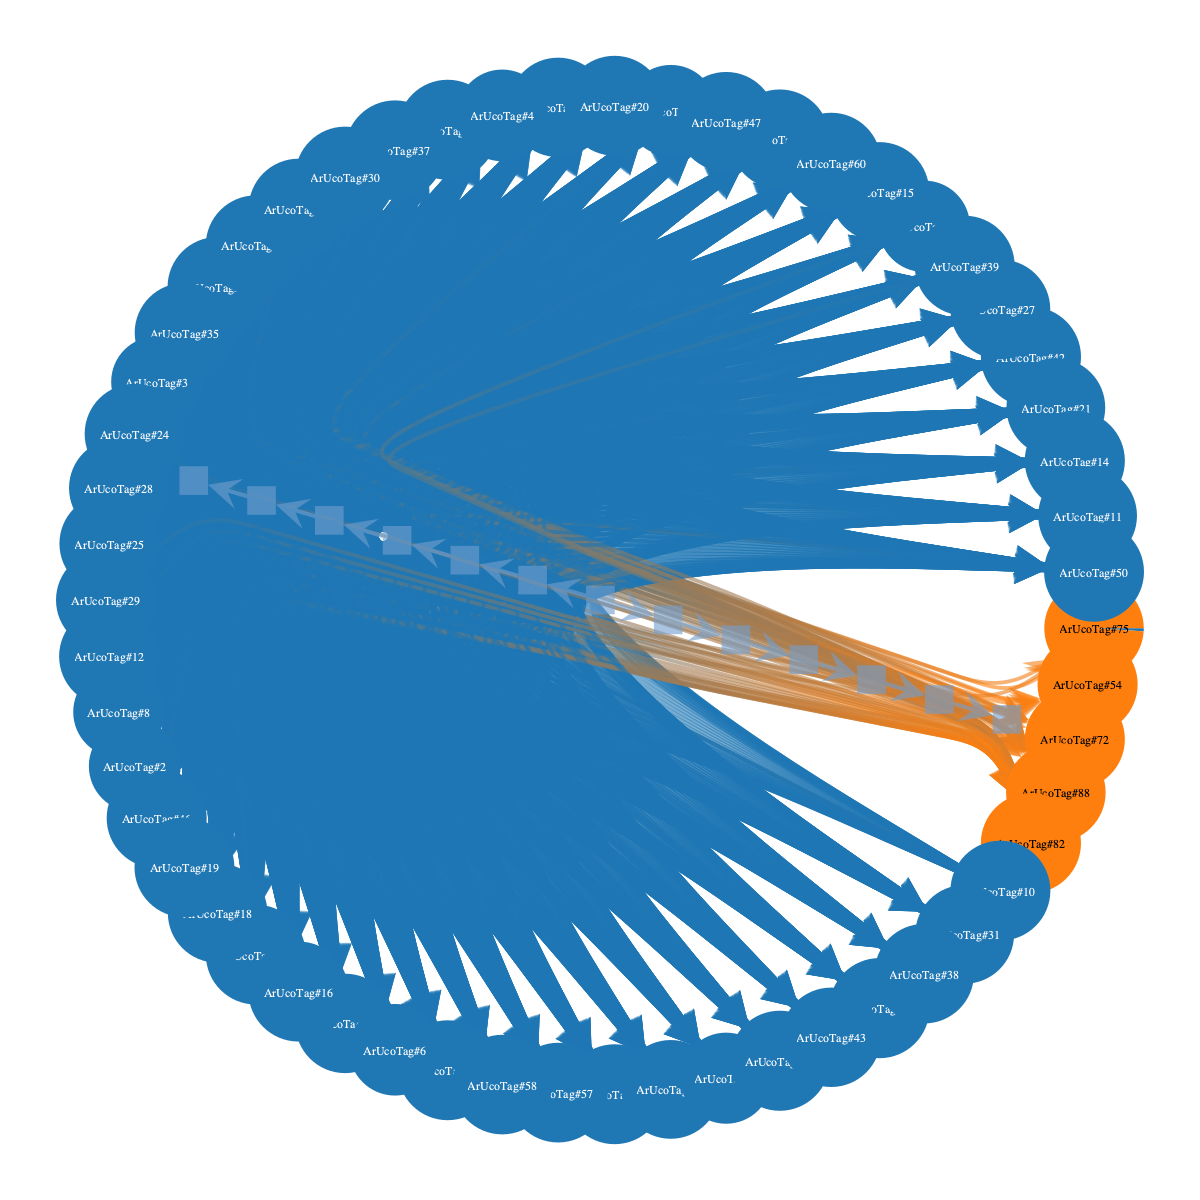

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x32e1a2180, at 0x30cd79f10>,
 <GraphView object, directed, with 68 vertices and 67 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x16be8eb10, at 0x16be8c800>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x16be8eb10, at 0x16be8f770>, False), at 0x16be8eb10>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x16be8eb10, at 0x16be8f680>)

In [47]:
# Disambiguate partitions and obtain marginals
pmode = gt.PartitionModeState(bs, converge=True,nested=True)
pv = pmode.get_marginal(g)

# Now the node marginals are stored in property map pv. We can
# visualize them as pie charts on the nodes:
state.draw( vertex_shape="pie", vertex_pie_fractions=pv,vertex_text=g.vertex_properties["id"], vertex_font_size=6)

In [45]:
[g.vp.id[v] for v in g.get_vertices()]

['ArUcoTag#10',
 'ArUcoTag#11',
 'ArUcoTag#13',
 'ArUcoTag#14',
 'ArUcoTag#15',
 'ArUcoTag#16',
 'ArUcoTag#18',
 'ArUcoTag#19',
 'ArUcoTag#2',
 'ArUcoTag#20',
 'ArUcoTag#21',
 'ArUcoTag#22',
 'ArUcoTag#23',
 'ArUcoTag#25',
 'ArUcoTag#26',
 'ArUcoTag#27',
 'ArUcoTag#28',
 'ArUcoTag#3',
 'ArUcoTag#30',
 'ArUcoTag#31',
 'ArUcoTag#32',
 'ArUcoTag#34',
 'ArUcoTag#35',
 'ArUcoTag#37',
 'ArUcoTag#38',
 'ArUcoTag#39',
 'ArUcoTag#4',
 'ArUcoTag#40',
 'ArUcoTag#42',
 'ArUcoTag#43',
 'ArUcoTag#44',
 'ArUcoTag#46',
 'ArUcoTag#47',
 'ArUcoTag#48',
 'ArUcoTag#49',
 'ArUcoTag#5',
 'ArUcoTag#50',
 'ArUcoTag#51',
 'ArUcoTag#55',
 'ArUcoTag#57',
 'ArUcoTag#58',
 'ArUcoTag#59',
 'ArUcoTag#6',
 'ArUcoTag#60',
 'ArUcoTag#7',
 'ArUcoTag#8',
 'ArUcoTag#9',
 'ArUcoTag#12',
 'ArUcoTag#24',
 'ArUcoTag#29',
 'ArUcoTag#82',
 'ArUcoTag#88',
 'ArUcoTag#75',
 'ArUcoTag#72',
 'ArUcoTag#54']

In [ ]:
g = graphs['RooibosTea_QR_1216_1646']['aggregate'].copy()
min_weighted_degree = 10000

# Function to calculate the sum of weights of edges connected to a vertex
def weighted_degree_sum(v, weight):
    result = sum(weight[e] for e in v.out_edges()) + sum(weight[e] for e in v.in_edges())
    return result 

weighted_degree_sum_dist = [weighted_degree_sum(v, g.ep.count) for v in g.vertices()]
plt.hist(weighted_degree_sum_dist, bins=100)
# # Find all vertices with a weighted degree less than the threshold
vertices_to_remove = [v for v in g.vertices() if weighted_degree_sum(v, g.ep.count) < min_weighted_degree]

print(len(vertices_to_remove))
print(len(list(g.vertices())))